<a href="https://colab.research.google.com/github/manasikhandekar9/Netflix-Recommender-System/blob/main/Netflix_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data and required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.sparse import save_npz
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [3]:
netflix_data = pd.read_csv("/content/drive/MyDrive/Netflix_Recommender/netflix_titles.csv")
netflix_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Exploratory Data Analysis



*   Understanding Variables
*   Cleaning the Dataset
*   Analyzing variable Relationships






In [4]:
netflix_data.shape

(8807, 12)

In [5]:
netflix_data.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [6]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [7]:
netflix_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
show_id,8807,8807,s1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,8807,2,Movie,6131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,8807,8807,Dick Johnson Is Dead,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,6173,4528,Rajiv Chilaka,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,7982,7692,David Attenborough,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,7976,748,United States,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,8797,1767,"January 1, 2020",109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,8807.0,NaN,NaN,NaN,2014.180198,8.819312,1925.0,2013.0,2017.0,2019.0,2021.0
rating,8803,17,TV-MA,3207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,8804,220,1 Season,1793,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
netflix_data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [9]:
netflix_data = netflix_data.dropna(subset=['rating', 'duration'])

Filling missing values with empty string as the columns for which values are missing are categorical.

In [10]:
netflix_data.fillna('', inplace=True)

In [11]:
netflix_data.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [12]:
netflix_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
show_id,8800,8800,s1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,8800,2,Movie,6126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,8800,8800,Dick Johnson Is Dead,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,8800,4527,,2631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,8800,7689,,825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,8800,749,United States,2815,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,8800,1766,"January 1, 2020",109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,8800.0,NaN,NaN,NaN,2014.179886,8.822583,1925.0,2013.0,2017.0,2019.0,2021.0
rating,8800,14,TV-MA,3207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,8800,220,1 Season,1791,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Data Visualizations**

In [13]:
import plotly.graph_objects as go
import plotly.express as px

- Distribution according to the type of content








In [14]:
content_type = netflix_data['type'].value_counts()

fig = go.Figure(data=go.Pie(labels=content_type.index, values=content_type.values))

fig.update_layout(
    plot_bgcolor='rgb(0, 0, 0)',
    paper_bgcolor='rgb(0, 0, 0)',
    font_color='white',
    title='Content Type Distribution',
)
fig.update_traces(marker=dict(colors=['rgb(176,7,16)','rgb(255,255,255)']))
fig.show()

Split data according to content type

In [15]:
shows, movies = [x for _, x in netflix_data.groupby(netflix_data['type'] == 'Movie')]

In [16]:
movies.shape

(6126, 12)

In [17]:
shows.shape

(2674, 12)

- Movie releases by year

In [18]:
movies_years = movies['release_year'].value_counts().sort_index()

fig = go.Figure(data=go.Bar(x=movies_years.index, y=movies_years.values))

fig.update_layout(
    plot_bgcolor='rgb(0, 0, 0)',
    paper_bgcolor='rgb(0, 0, 0)',
    font_color='white',
    title='Movie Releases Every Year',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Number of Movies')
)
fig.update_traces(marker_color='rgb(176,7,16)')
fig.show()

- TV Show releases by year

In [19]:
shows_years = shows['release_year'].value_counts().sort_index()

fig = go.Figure(data=go.Bar(x=shows_years.index, y=shows_years.values))

fig.update_layout(
    plot_bgcolor='rgb(0, 0, 0)',
    paper_bgcolor='rgb(0, 0, 0)',
    font_color='white',
    title='TV Show Releases Every Year',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Number of TV Shows')
)
fig.update_traces(marker_color='rgb(176,7,16)')
fig.show()

- Top 10 countries with content

In [20]:
top_countries = netflix_data['country'].value_counts().head(10)

fig = px.treemap(names=top_countries.index, parents=["" for _ in top_countries.index], values=top_countries.values)

fig.update_layout(
    plot_bgcolor='rgb(0, 0, 0)',
    paper_bgcolor='rgb(0, 0, 0)',
    font_color='white',
    title='Top 10 Countries with Most Content',
)
fig.show()

- Ratings Distribution

In [21]:
grouped_df = netflix_data.groupby(['rating', 'type']).size().reset_index(name='count')

#print(grouped_df)

# Plot the bar chart
fig = px.bar(grouped_df, x='rating', y='count', color='type', barmode='group', color_discrete_map={'Movie':'rgb(176,6,17)', 'TV Show':'white',})

# Set the layout
fig.update_layout(
    plot_bgcolor='rgb(0, 0, 0)',
    paper_bgcolor='rgb(0, 0, 0)',
    font_color='white',
    title='Ratings Distribution by Content Type',
    xaxis_title='Rating',
    yaxis_title='Count'
)

# Show the plot
fig.show()

- Duration Distribution for Movies

In [22]:
movies['duration'] = movies['duration'].str.extract('(\d+)', expand=False).astype(int)
movies_duration = movies['duration'].value_counts().sort_index(ascending=True)

fig = go.Figure(data=go.Bar(x=movies_duration.index.astype(str), y=movies_duration.values))

fig.update_layout(
    plot_bgcolor='rgb(0, 0, 0)',
    paper_bgcolor='rgb(0, 0, 0)',
    font_color='white',
    title='Movie Duration Distribution',
    xaxis=dict(title='Duration (in mins)'),
    yaxis=dict(title='Number of Movies')
)
fig.update_traces(marker_color='rgb(176,7,16)')
fig.show()

- Duration Distribution for TV Shows

In [23]:
shows['duration'] = shows['duration'].str.extract('(\d+)', expand=False).astype(int)
shows_duration = shows['duration'].value_counts().sort_index()

fig = go.Figure(data=go.Bar(x=shows_duration.index.astype(str), y=shows_duration.values))

fig.update_layout(
    plot_bgcolor='rgb(0, 0, 0)',
    paper_bgcolor='rgb(0, 0, 0)',
    font_color='white',
    title='TV Show Duration Distribution',
    xaxis=dict(title='Duration (in seasons)'),
    yaxis=dict(title='Number of TV Shows')
)
fig.update_traces(marker_color='rgb(176,7,16)')
fig.show()

- Wordclouds

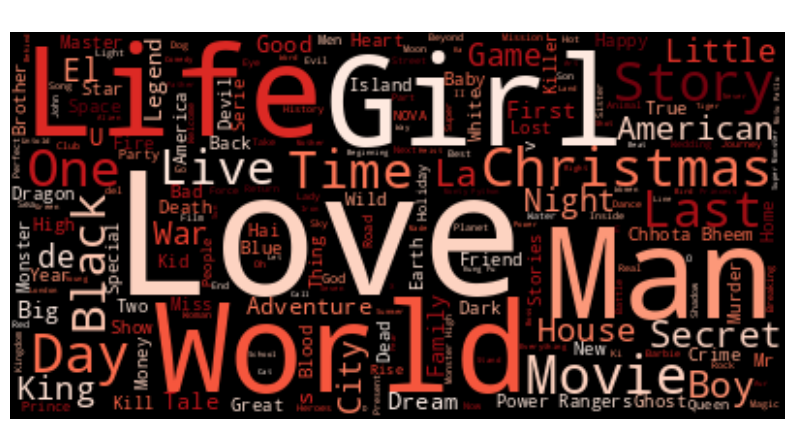

In [24]:
titles = netflix_data['title'].values
text = ' '.join(titles)

wordcloud = WordCloud(background_color='black', colormap='Reds').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Titles', color='white')
plt.show()

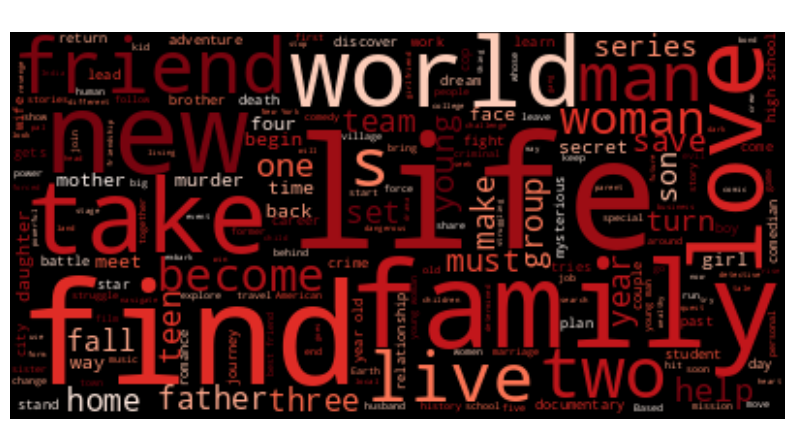

In [25]:
titles = netflix_data['description'].values

text = ' '.join(titles)

wordcloud = WordCloud(background_color='black', colormap='Reds').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Descriptions', color='white')
plt.show()

- Movies Genre Distribution

In [26]:
movies1 = movies
mgenres_dummies = movies1['listed_in'].str.get_dummies(sep=', ')
mcolumn_value_counts = mgenres_dummies.sum(axis=0)

fig = go.Figure(data=go.Bar(x=mcolumn_value_counts.index, y=mcolumn_value_counts.values))

fig.update_layout(
    plot_bgcolor='rgb(0, 0, 0)',
    paper_bgcolor='rgb(0, 0, 0)',
    font_color='white',
    title='Movies Genre Distribution',
    xaxis=dict(title='Genres'),
    yaxis=dict(title='Count')
)
fig.update_traces(marker_color='rgb(176,7,16)')
# Show the plot
fig.show()

- TV Shows Genre Distribution

In [27]:
shows1 = shows
sgenres_dummies = shows1['listed_in'].str.get_dummies(sep=', ')
scolumn_value_counts = sgenres_dummies.sum(axis=0)

fig = go.Figure(data=go.Bar(x=scolumn_value_counts.index, y=scolumn_value_counts.values))

fig.update_layout(
    plot_bgcolor='rgb(0, 0, 0)',
    paper_bgcolor='rgb(0, 0, 0)',
    font_color='white',
    title='TV Shows Genre Distribution',
    xaxis=dict(title='Genres'),
    yaxis=dict(title='Count')
)
fig.update_traces(marker_color='rgb(176,7,16)')
# Show the plot
fig.show()

# Recommender System

Implementing a recommendation system by training an autoencoder using cosine similarity score

- Data Preprocessing & Feature Extraction



1.   Cleaning textual columns
2.   Converting duration column in a uniform unit
3.   Extracting features
4.   Encoding and Scaling features

After some trial and error, found the best data columns to use to get a more accurate recommender system

In [40]:
data = netflix_data[['title', 'type', 'release_year', 'duration', 'director', 'country', 'rating', 'listed_in']]
data.set_index('title', inplace=True)
data.head()

,type,release_year,duration,director,country,rating,listed_in
title,,,,,,,
Dick Johnson Is Dead,Movie,2020,90 min,Kirsten Johnson,United States,PG-13,Documentaries
Blood & Water,TV Show,2021,2 Seasons,,South Africa,TV-MA,"International TV Shows, TV Dramas, TV Mysteries"
Ganglands,TV Show,2021,1 Season,Julien Leclercq,,TV-MA,"Crime TV Shows, International TV Shows, TV Act..."
Jailbirds New Orleans,TV Show,2021,1 Season,,,TV-MA,"Docuseries, Reality TV"
Kota Factory,TV Show,2021,2 Seasons,,India,TV-MA,"International TV Shows, Romantic TV Shows, TV ..."


In [41]:
def clean_text(text):
  unique_texts = set()
  for text in text.split(','):
      unique_texts.add(text.strip().lower())
  unique_text = ' '.join(unique_texts)
  unique_text = unique_text.translate(str.maketrans('', '', string.punctuation))
  return unique_text

In [42]:
data['type']        = data['type'].apply(clean_text)
data['director']    = data['director'].apply(clean_text)
data['country']        = data['country'].apply(clean_text)
data['rating']      = data['rating'].apply(clean_text)
data['listed_in']   = data['listed_in'].apply(clean_text)
data.head()

,type,release_year,duration,director,country,rating,listed_in
title,,,,,,,
Dick Johnson Is Dead,movie,2020,90 min,kirsten johnson,united states,pg13,documentaries
Blood & Water,tv show,2021,2 Seasons,,south africa,tvma,tv dramas tv mysteries international tv shows
Ganglands,tv show,2021,1 Season,julien leclercq,,tvma,tv action adventure international tv shows cr...
Jailbirds New Orleans,tv show,2021,1 Season,,,tvma,docuseries reality tv
Kota Factory,tv show,2021,2 Seasons,,india,tvma,tv comedies international tv shows romantic tv...


In [43]:
def converting_to_minutes(duration):
    if "Season" in duration:
        num_seasons = int(duration.split()[0])
        return num_seasons * 300                      #Avg of 15 episodes of 20 mins duration each
    else:
        return int(duration.split()[0])

data['duration'] = data['duration'].apply(converting_to_minutes)

data.head()

,type,release_year,duration,director,country,rating,listed_in
title,,,,,,,
Dick Johnson Is Dead,movie,2020,90,kirsten johnson,united states,pg13,documentaries
Blood & Water,tv show,2021,600,,south africa,tvma,tv dramas tv mysteries international tv shows
Ganglands,tv show,2021,300,julien leclercq,,tvma,tv action adventure international tv shows cr...
Jailbirds New Orleans,tv show,2021,300,,,tvma,docuseries reality tv
Kota Factory,tv show,2021,600,,india,tvma,tv comedies international tv shows romantic tv...


In [44]:
data.reset_index(inplace=True)
X = data.drop('title', axis=1)
y = data['title']

In [45]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

mms = MinMaxScaler()
ohe = OneHotEncoder(drop='first')
cv = CountVectorizer()

# make_column_transformer object
preprocessor = make_column_transformer(
    (mms, ['release_year']),
    (mms, ['duration']),
    (ohe, ['type', 'director', 'rating']),
    (cv, 'country'),
    (cv, 'listed_in')
)

X_processed  = preprocessor.fit_transform(X)

X_processed = X_processed.toarray()

X_processed

array([[0.98958333, 0.01706886, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.11712772, 1.        , ..., 0.        , 0.        ,
        3.        ],
       [1.        , 0.05826957, 1.        , ..., 0.        , 0.        ,
        3.        ],
       ...,
       [0.875     , 0.01667648, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.84375   , 0.01667648, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9375    , 0.02118893, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [34]:
!pip install keras-tuner

In [46]:
from keras.metrics import cosine_similarity
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf

# Metric to test the accuracy of reconstructed features
def cosine_similarity_metric(y_true, y_pred):
    return tf.reduce_mean(cosine_similarity(y_true, y_pred))

# Function for building diffrent models using keras_tuner
def build_model(hp):
    input_shape = X_processed.shape[1]
    input_layer = Input(shape=(input_shape,))

    outer_units = hp.Int('outer_units', min_value=128, max_value=128, step=64)
    inner_units = hp.Int('inner_units', min_value=32, max_value=128, step=32)
    bottleneck = hp.Int('bottleneck', min_value=32, max_value=32, step=8)

    hidden_layer1 = Dense(units=outer_units, activation='relu')(input_layer)
    hidden_layer2 = Dense(units=inner_units, activation='relu')(hidden_layer1)
    hidden_layer3 = Dense(units=bottleneck, activation='relu')(hidden_layer2)
    hidden_layer4 = Dense(units=inner_units, activation='relu')(hidden_layer3)
    hidden_layer5 = Dense(units=outer_units, activation='relu')(hidden_layer4)

    output_layer = Dense(units=input_shape, activation='sigmoid')(hidden_layer5)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse', metrics=[cosine_similarity_metric])

    return model

In [47]:
from keras_tuner import BayesianOptimization

# Creating BayesianOptimization instance
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=1, # number of different architectures
    executions_per_trial=1) # number of repeats given architecture

In [48]:
# Information about what space of parameters are search for
tuner.search_space_summary()

Search space summary
Default search space size: 3
outer_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 128, 'step': 64, 'sampling': 'linear'}
inner_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
bottleneck (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 32, 'step': 8, 'sampling': 'linear'}


In [49]:
# Running BayesianOptimization tuner
tuner.search(X_processed, X_processed, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

Trial 1 Complete [00h 02m 22s]
val_loss: 0.0009617971954867244

Best val_loss So Far: 0.0009617971954867244
Total elapsed time: 00h 02m 22s


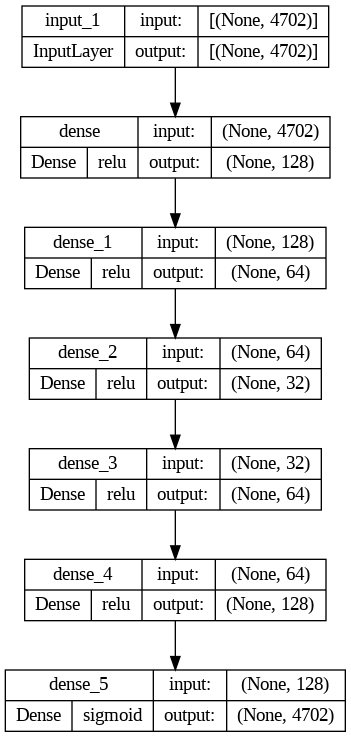

In [50]:
from tensorflow.keras.utils import plot_model

# Loading best model
autoencoder = tuner.get_best_models(num_models=1)[0]

# Displaying a graphical representation of the best model
plot_model(autoencoder, show_shapes=True, show_layer_activations=True)

In [51]:
# Training best architecture
history = autoencoder.fit(X_processed, X_processed, epochs=25)

Epoch 1/25
275/275 [==============================] - 9s 27ms/step - loss: 8.9444e-04 - cosine_similarity_metric: 0.7803
Epoch 2/25
275/275 [==============================] - 6s 20ms/step - loss: 8.3683e-04 - cosine_similarity_metric: 0.7988
Epoch 3/25
275/275 [==============================] - 7s 25ms/step - loss: 8.0771e-04 - cosine_similarity_metric: 0.8081
Epoch 4/25
275/275 [==============================] - 6s 21ms/step - loss: 7.9173e-04 - cosine_similarity_metric: 0.8136
Epoch 5/25
275/275 [==============================] - 6s 21ms/step - loss: 7.8202e-04 - cosine_similarity_metric: 0.8170
Epoch 6/25
275/275 [==============================] - 7s 26ms/step - loss: 7.7278e-04 - cosine_similarity_metric: 0.8201
Epoch 7/25
275/275 [==============================] - 6s 20ms/step - loss: 7.6451e-04 - cosine_similarity_metric: 0.8228
Epoch 8/25
275/275 [==============================] - 7s 27ms/step - loss: 7.5975e-04 - cosine_similarity_metric: 0.8243
Epoch 9/25
275/275 [============

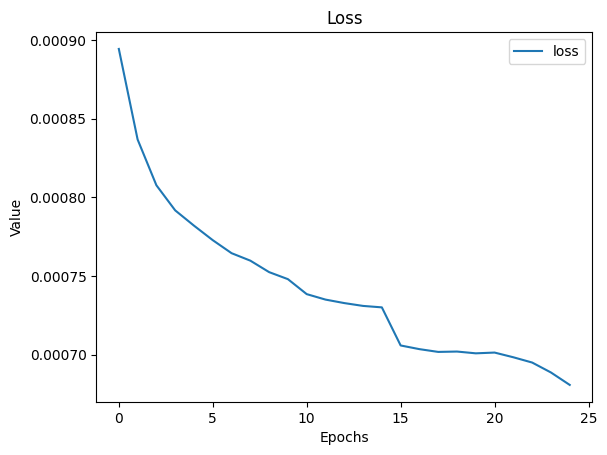

In [52]:
# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

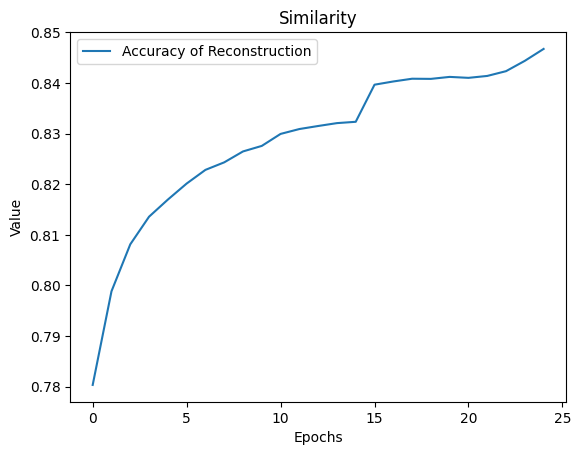

In [53]:
# Plotting cosine_similarity_metric
plt.plot(history.history['cosine_similarity_metric'], label='Accuracy of Reconstruction')
plt.title('Similarity')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

# Recommend Movies

Given a sample movie/tv show, recommend 5 more

In [62]:
movie = "Kota Factory"

movie_features = y.index[y == movie][0]

movie_features_processed = X_processed[movie_features]

movie_features_processed

array([1.        , 0.11712772, 1.        , ..., 0.        , 0.        ,
       3.        ])

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

N_movies = 5

reconstructed_movie = autoencoder.predict(np.array([movie_features_processed]))[0]

similarities = cosine_similarity(X_processed, [reconstructed_movie])
similarities[movie_features] = -1  # Making sure the original movie will not be recomended
most_similar_indices = np.argsort(similarities, axis=0)[::-1][:N_movies]

most_similar_indices

1/1 [==============================] - 0s 24ms/step


array([[ 242],
       [5155],
       [6901],
       [ 577],
       [ 682]])

In [64]:
# Printing recomended movies
for recomended_movie in most_similar_indices:
    print(*y.values[recomended_movie])

Comedy Premium League
Trailer Park Boys: Out of the Park: USA
Ha Unlimited
Masameer County
Why Are You Like This
